#### author: Brian T. Quinn, Ph.D.
#### date: 06/17/2016
#### email: btquinn@gmail.com

## QUESTIONS
1.When presented with a new dataset or database, what steps do you generally take
to evaluate it prior to working with it?

**Depending on the size of the data, I like to look it over in a spreadsheet form to get a sense of the columns and data types I will be dealing with. I look for missing data, duplicate rows, incorrect entries. Then I plot the data to identify outliers. Finally, I convert columns to a suitable data format.**

2.Based on the information provided above and the attached dataset, what 3
questions would you like to understand prior to conducting any analysis of the
data?

* **1. Is the data accurate? That is, does it contain obvious outliers that indicate a human error in recording/entering the data. If it does have missing values, then...**

* **2. Can I fill in missing values? Whether it be by obtaining data from the source or to interpolate missing values that do not compromise the analysis.**

* **3. Do the data exhibit any bevavior I should be on the lookout for? I want to know if there is a trend I can confirm or outliers that are to be expected.**

3.How would you prep the dataset provided for analysis?  Please list steps taken and
provide code used to prep the tables for analysis.

**View the data in a spreadsheet editing program. I get a sense of what data resides in each sheet and how they are related to one another. Delete any obvious junk, like the last two lines in the patients sheet and the dates from the future in the administered sheet. Next, I save each sheet to a seperate .csv and read each one in and process it. Empty values are dropped when necessary (like dates - no obvious way to interpolate a missing date in this dataset.). Illegal values are checked for as well. There were 6 patients with an unknown gender. This may be because it wasn't entered or that the form was to gender restrictive for the patient to identify.  I kept these patients in the data set and changed the stratifying code a bit to include them as much as I could.**

Using the datasets you have prepped, please answer the following questions and provide
all code/output used. Be sure to include and explain any assumptions made when
answering each question.

 
1.What is the average time elapsed between a patient’s initial diagnosis date and a patient’s first treatment?  Does this time vary by gender?

**When I calculated days from diagnosis to treatment, some values were negative, indicating that the drug was administered before the diagnosis. As I believe this would alter the results and was not the intent of the question, I removed those negative values. The average time between a patient's initial diagnosis date and a patient's first treatment is 14025 days. For femal patient's the mean was 15114 days and for male patient's it was 12694. These two means are not different in a statistically significant way (indepentdent t-test, alpha=.05, pvalue=.21). **

2.How many patients are on nivolumab from 2012-2016?

**61 patients on nivolumab from 2012-2016**

3.Using the following risk stratification rules, please summarize the number of high,
medium, and low risk patients.

* HighRisk       = Female; any age; NON_WHITE       OR  Male; >= 70; NON_WHITE
 
* MediumRisk = Female; >=75, WHITE  OR  Male; <70; NON_WHITE
 
* LowRisk       = Female; < 75, WHITE  OR  Male; any­age; WHITE

**31 High Risk patients range in age from 9-98 (median=75,mean=65), are 71% female, 19% male, 10% unknown gender and all non-white.**

**19 Medium Risk patients range in age from 6-99 (median=62,mean=56), are 47% female, 53% male, 53% non-white, 47% white.**

**47 Low Risk patients range in age from 3-98 (median=38,mean=44), are 50% female, 50% male, and all white**

**2 patients could not be stratified by risk due to missing/incomplete information**

4.Please create a visualization that could be used to help a medical researcher
understand how drug prevalence has changed over time.

<img src="drug_prevalence.png">

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

admins_f = 'flatiron_qs_orders_admins_admins.csv'
demos_f = 'flatiron_qs_orders_admins_demographs.csv'
orders_f = 'flatiron_qs_orders_admins_orders.csv'
patients_f = 'flatiron_qs_orders_admins_patients.csv'
practices_f = 'flatiron_qs_orders_admins_practices.csv'

## Orders

In [2]:
orders_df = pd.read_csv(orders_f)
print orders_df.shape
# drop any duplicated lines, those with same order_id and order_date
orders_df = orders_df.drop_duplicates(subset=['order_id','order_date'])
print orders_df.shape
orders_df.head(2)

(304, 4)
(304, 4)


,patient_id,external_patient_id,order_id,order_date
0,h9993d,70,w187808812917e,13-Dec-2012
1,h9993d,70,r90118525421e,7-Aug-2015


Medication **orders** 
* **patient_id** :  patient identifier for internal purposes
*  **external_patient_id** :  patient identifier for external (client) purposes
*  **order_id** :   unique identifier of each medication ordered by a health provider
*  **order_date** :  date in which medication was ordered by a health provider

## Administrations

In [3]:
admins_df = pd.read_csv(admins_f)
print admins_df.shape
# drop any duplicated lines, those with same order_id and administered_date
admins_df = admins_df.drop_duplicates(subset=['order_id','administered_date'])
admins_df.dropna(inplace=True)
print admins_df.shape
admins_df.head(2)

(304, 5)
(297, 5)


,patient_id,external_patient_id,order_id,administered_date,drug_name
0,h9993d,70,w187808812917e,13-Dec-2012,bevacizumab
1,h9993d,70,r90118525421e,7-Aug-2015,nivolumab


Medication **administrations**

 * **patient_id** :  patient identifier for internal purposes
 * **external_patient_id** :   patient identifier for external (client) purposes
 * **order_id** :  unique identifier of each medication ordered for a patient by a health provider
 * **administered_date** :  date in which ordered medication was administered
 * **drug_name** :   drug administered to patient

### Question 4. Please create a visualization that could be used to help a medical researcher understand how drug prevalence has changed over time.

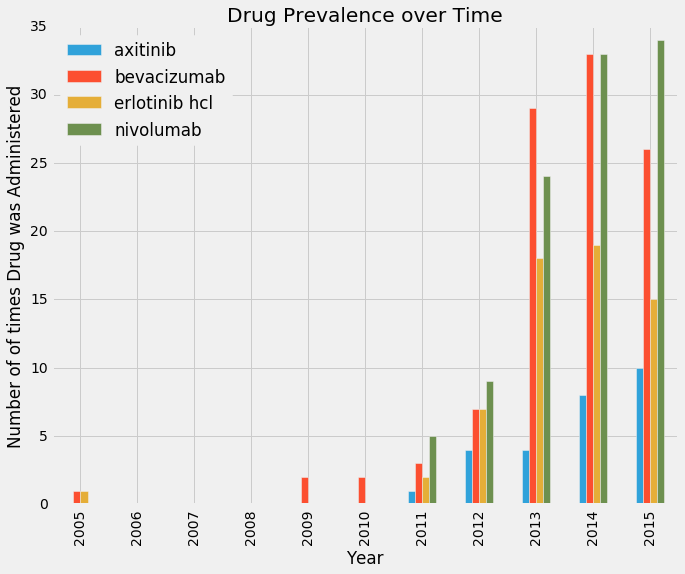

In [4]:
# make a copy of admins_df, dropping fields no longer needed for Question 4
q4_df = admins_df.drop(['patient_id','external_patient_id','order_id'],axis=1)
q4_df.dropna(inplace=True) #dropna from blank dates
q4_df['admin_dt']=pd.to_datetime(q4_df['administered_date'],infer_datetime_format=True)
q4_df = q4_df.join(pd.get_dummies(q4_df['drug_name']))
q4_df.drop(['administered_date','drug_name'],axis=1,inplace='True')
q4_df.set_index(['admin_dt'],inplace='True')

#Resample the date and sum each drug administered over that period ('A' = annual)
resampled_q4 = q4_df.resample('A').sum()
#print resampled_q4.tail()
with plt.style.context('fivethirtyeight'):
    resampled_q4.plot.bar()#(kind='bar', stacked=True)
    f = plt.gcf()
    ax = plt.gca()
    f.set_size_inches(10,8)
    xmj =  ax.get_xmajorticklabels()
    for x in xmj:
        x.set_text(x.get_text()[:4])
        #x[2]=x[2][:5]
        #print x[2]
    ax.set_xticklabels(xmj)
    ax.set_title('Drug Prevalence over Time')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of of times Drug was Administered')
    plt.show()

## Demographics

In [5]:
demos_df = pd.read_csv(demos_f)
print demos_df.shape
demos_df.drop_duplicates(subset=['patient_id'],inplace='True')
print demos_df.shape
demos_df.head()

(101, 4)
(99, 4)


,patient_id,gender,age,race
0,h9993d,female,69.0,NON_WHITE
1,w9986a,female,46.0,WHITE
2,n9925d,female,84.0,NON_WHITE
3,a9913g,female,14.0,NON_WHITE
4,t9815h,female,97.0,WHITE


Patient **demographics**
*  **patient_id**:   patient identifier for internal purposes
*  **gender** :  gender of patient
*  **age** :  age of patient at the time of diagnosis
*  **race**:   racial group classification of patient

### Question 3.  Using the following risk stratification rules, please summarize the number of high,medium, and low risk patients.
* HighRisk   = Female; any age; NON_WHITE  OR  Male; >= 70; NON_WHITE
* MediumRisk = Female; >=75, WHITE  OR  Male; <70; NON_WHITE
* LowRisk    = Female; < 75, WHITE  OR  Male; any­age; WHITE

In [6]:
print demos_df['gender'].value_counts()
print demos_df['race'].value_counts()

female     50
male       43
unknown     6
Name: gender, dtype: int64
WHITE        57
NON_WHITE    42
Name: race, dtype: int64


In [7]:
demos_df[demos_df['gender']=='unknown']

,patient_id,gender,age,race
25,w7942e,unknown,100.0,WHITE
33,z7390g,unknown,84.0,NON_WHITE
35,g7173d,unknown,87.0,NON_WHITE
40,a6991u,unknown,95.0,NON_WHITE
54,g5736q,unknown,62.0,NON_WHITE
76,w3752a,unknown,7.0,WHITE


of the 6 listed above, we can assess the risk of 4 out of the six given the criteria above with the following rules:
*    HighRisk : race == 'NON_WHITE' and age > 70
*    LowRisk : race == 'WHITE' and age < 75

In [8]:
def stratify_risk(row):
    #demo_row is a row from the demographics data. It consists of the following columns:
    # patient_id, gender, age, race
    if (row.gender=='female' and row.race=='NON_WHITE') or (row.gender=='male' and row.age>=70 and row.race=='NON_WHITE'):
            return 'HighRisk'
    if (row.gender=='female' and row.age>=75 and row.race=='WHITE') or (row.gender=='male' and row.age<70 and row.race=='NON_WHITE'):
            return 'MediumRisk'
    if (row.gender=='female' and row.age<75 and row.race=='WHITE') or (row.gender=='male' and row.race=='WHITE'):
            return 'LowRisk'
    if (row.race=='NON_WHITE' and row.age>70):
            return 'HighRisk'
    if (row.race=='WHITE' and row.age < 75):
            return 'LowRisk'

demos_df['risk']=demos_df.apply(stratify_risk,axis=1)
demos_df.head()

,patient_id,gender,age,race,risk
0,h9993d,female,69.0,NON_WHITE,HighRisk
1,w9986a,female,46.0,WHITE,LowRisk
2,n9925d,female,84.0,NON_WHITE,HighRisk
3,a9913g,female,14.0,NON_WHITE,HighRisk
4,t9815h,female,97.0,WHITE,MediumRisk


In [9]:
demos_df = demos_df.join(pd.get_dummies(demos_df['gender'], prefix = 'gender'))
demos_df = demos_df.join(pd.get_dummies(demos_df['race'], prefix='race'))
demos_df.head()

,patient_id,gender,age,race,risk,gender_female,gender_male,gender_unknown,race_NON_WHITE,race_WHITE
0,h9993d,female,69.0,NON_WHITE,HighRisk,1.0,0.0,0.0,1.0,0.0
1,w9986a,female,46.0,WHITE,LowRisk,1.0,0.0,0.0,0.0,1.0
2,n9925d,female,84.0,NON_WHITE,HighRisk,1.0,0.0,0.0,1.0,0.0
3,a9913g,female,14.0,NON_WHITE,HighRisk,1.0,0.0,0.0,1.0,0.0
4,t9815h,female,97.0,WHITE,MediumRisk,1.0,0.0,0.0,0.0,1.0


In [10]:
print demos_df.groupby('risk')['age'].median()
demos_df.groupby('risk').describe()

risk
HighRisk      75.0
LowRisk       38.0
MediumRisk    62.0
Name: age, dtype: float64


age  gender_female  gender_male  gender_unknown  \
risk                                                                      
HighRisk   count  31.000000      31.000000    31.000000       31.000000   
           mean   64.967742       0.709677     0.193548        0.096774   
           std    29.460124       0.461414     0.401610        0.300537   
           min     9.000000       0.000000     0.000000        0.000000   
           25%    38.500000       0.000000     0.000000        0.000000   
           50%    75.000000       1.000000     0.000000        0.000000   
           75%    87.000000       1.000000     0.000000        0.000000   
           max    98.000000       1.000000     1.000000        1.000000   
LowRisk    count  47.000000      47.000000    47.000000       47.000000   
           mean   44.234043       0.404255     0.574468        0.021277   
           std    28.511792       0.496053     0.499769        0.145865   
           min     3.000000       0.000000     0.000000        0.000000   
           25%    21.500000       0.000000     0.000000        0.000000   
           50%    38.000000       0.000000     1.000000        0.000000   
           75%    66.000000       1.000000     1.000000        0.000000   
           max    98.000000       1.000000     1.000000        1.000000   
MediumRisk count  19.000000      19.000000    19.000000       19.000000   
           mean   56.263158       0.473684     0.526316        0.000000   
           std    32.756411       0.512989     0.512989        0.000000   
           min     6.000000       0.000000     0.000000        0.000000   
           25%    30.000000       0.000000     0.000000        0.000000   
           50%    62.000000       0.000000     1.000000        0.000000   
           75%    83.500000       1.000000     1.000000        0.000000   
           max    99.000000       1.000000     1.000000        0.000000   

                  race_NON_WHITE  race_WHITE  
risk                                          
HighRisk   count       31.000000   31.000000  
           mean         1.000000    0.000000  
           std          0.000000    0.000000  
           min          1.000000    0.000000  
           25%          1.000000    0.000000  
           50%          1.000000    0.000000  
           75%          1.000000    0.000000  
           max          1.000000    0.000000  
LowRisk    count       47.000000   47.000000  
           mean         0.000000    1.000000  
           std          0.000000    0.000000  
           min          0.000000    1.000000  
           25%          0.000000    1.000000  
           50%          0.000000    1.000000  
           75%          0.000000    1.000000  
           max          0.000000    1.000000  
MediumRisk count       19.000000   19.000000  
           mean         0.526316    0.473684  
           std          0.512989    0.512989  
           min          0.000000    0.000000  
           25%          0.000000    0.000000  
           50%          1.000000    0.000000  
           75%          1.000000    1.000000  
           max          1.000000    1.000000

31 High Risk patients range in age from 9-98 (median=75,mean=65), are 71% female, 19% male, 10% unknown gender and all non-white.
19 Medium Risk patients range in age from 6-99 (median=62,mean=56), are 47% female, 53% male, 53% non-white, 47% white.
47 Low Risk patients range in age from 3-98 (median=38,mean=44), are 50% female, 50% male, and all white.
2 patients could not be stratified by risk due to missing/incomplete information

## Patients

In [11]:
patients_df = pd.read_csv(patients_f)
print patients_df.shape
patients_df.drop_duplicates(subset=['patient_id','diagnosis_date'],inplace=True)
print patients_df.shape
patients_df.head()

(102, 6)
(99, 6)


,patient_id,external_patient_id,external_practice_id,internal_practice_id,diagnosis_date,advanced_diagnosis_date
0,h9993d,70,QZ1,9,29-Mar-1992,NaN
1,w9986a,46,ZE4G,4,15-Feb-2012,3-Jul-2012
2,n9925d,15,FUM35,5,5-Jul-1962,18-May-2009
3,a9913g,6,DSVN67,7,16-Oct-1930,14-Sep-1970
5,t9815h,82,DSVN67,7,13-Nov-1988,17-Dec-1989


**Patients**
*  **patient_id**:   patient identifier for internal purposes
*  **external_patient_id** :   patient identifier for external purposes
*  **external_practice_id** :  practice identifier for external purposes
*  **internal_practice_id** :   practice (site at which patient receives oncology care) identifier for Internal purposes
*  **diagnosis_date** :  date on which patient was initially diagnosed
*  **advanced_diagnosis_date** :   date on which patient was diagnosed as advanced

In [12]:
patients_df.duplicated(subset=['patient_id','diagnosis_date']).sum()

0

## Practices

In [13]:
practices_df = pd.read_csv(practices_f)
print practices_df.shape
practices_df.head()

(10, 5)


,practice_id,external_practice_id,emr_system,practice_type,active
0,QZ1,9,OncoE,community,active
1,ZE4G,4,OncoA,community,inactive
2,FUM35,5,OncoA,academic,active
3,DSVN67,7,OncoE,community,inactive
4,FZAB,1,OncoB,community,active


**Practices**
*  **practice_id** :   client identifier for internal purposes
*  **external_practice_id** :  client identifier for external (client) purposes
*  **emr_system** :  software product used by the client (OncoE = OncoEMR; OncoA = OncoAnalytics; OncoB = OncoBilling)
*  **practice_type** :  classification of practice into either community or academic bucket
*  **active** :   status of client

In [14]:
patdemo_df = pd.merge(patients_df,demos_df,on=['patient_id'])
print patdemo_df.shape
patdemo_df.head()

(99, 15)


,patient_id,external_patient_id,external_practice_id,internal_practice_id,diagnosis_date,advanced_diagnosis_date,gender,age,race,risk,gender_female,gender_male,gender_unknown,race_NON_WHITE,race_WHITE
0,h9993d,70,QZ1,9,29-Mar-1992,NaN,female,69.0,NON_WHITE,HighRisk,1.0,0.0,0.0,1.0,0.0
1,w9986a,46,ZE4G,4,15-Feb-2012,3-Jul-2012,female,46.0,WHITE,LowRisk,1.0,0.0,0.0,0.0,1.0
2,n9925d,15,FUM35,5,5-Jul-1962,18-May-2009,female,84.0,NON_WHITE,HighRisk,1.0,0.0,0.0,1.0,0.0
3,a9913g,6,DSVN67,7,16-Oct-1930,14-Sep-1970,female,14.0,NON_WHITE,HighRisk,1.0,0.0,0.0,1.0,0.0
4,t9815h,82,DSVN67,7,13-Nov-1988,17-Dec-1989,female,97.0,WHITE,MediumRisk,1.0,0.0,0.0,0.0,1.0


In [15]:
#merge administered data with patient/demo data
patdemoadmin_df = pd.merge(admins_df,patdemo_df,on=['patient_id','external_patient_id'])
del patdemoadmin_df['advanced_diagnosis_date']
print patdemoadmin_df.shape
#convert dates to datetime
patdemoadmin_df['admin_dt']=pd.to_datetime(patdemoadmin_df['administered_date'],infer_datetime_format=True)
patdemoadmin_df['diagn_dt']=pd.to_datetime(patdemoadmin_df['diagnosis_date'],infer_datetime_format=True)
print patdemoadmin_df.shape
patdemoadmin_df.dropna(subset=['diagnosis_date','administered_date'],inplace=True)
#calculate days between diagnosis and each administered date
patdemoadmin_df['diag_to_admin_dt']=patdemoadmin_df['admin_dt']-patdemoadmin_df['diagn_dt']
patdemoadmin_df['days_from_diag_to_admin']=patdemoadmin_df['diag_to_admin_dt'].apply(lambda x: x.days)
print patdemoadmin_df.shape
patdemoadmin_df.head()

(294, 17)
(294, 19)
(287, 21)


,patient_id,external_patient_id,order_id,administered_date,drug_name,external_practice_id,internal_practice_id,diagnosis_date,gender,age,...,risk,gender_female,gender_male,gender_unknown,race_NON_WHITE,race_WHITE,admin_dt,diagn_dt,diag_to_admin_dt,days_from_diag_to_admin
0,h9993d,70,w187808812917e,13-Dec-2012,bevacizumab,QZ1,9,29-Mar-1992,female,69.0,...,HighRisk,1.0,0.0,0.0,1.0,0.0,2012-12-13,1992-03-29,7564 days,7564
1,h9993d,70,r90118525421e,7-Aug-2015,nivolumab,QZ1,9,29-Mar-1992,female,69.0,...,HighRisk,1.0,0.0,0.0,1.0,0.0,2015-08-07,1992-03-29,8531 days,8531
2,h9993d,70,h84358125584w,30-Sep-2015,bevacizumab,QZ1,9,29-Mar-1992,female,69.0,...,HighRisk,1.0,0.0,0.0,1.0,0.0,2015-09-30,1992-03-29,8585 days,8585
3,h9993d,70,o81913333209g,8-Jan-2014,nivolumab,QZ1,9,29-Mar-1992,female,69.0,...,HighRisk,1.0,0.0,0.0,1.0,0.0,2014-01-08,1992-03-29,7955 days,7955
4,h9993d,70,e76139113344l,11-Oct-2012,erlotinib hcl,QZ1,9,29-Mar-1992,female,69.0,...,HighRisk,1.0,0.0,0.0,1.0,0.0,2012-10-11,1992-03-29,7501 days,7501


## Question 2. How many patients are on nivolumab from 2012-2016?
To answer this, I will filter the data for drug (nivolumab), dates (1/1/2012 to 12/31/2015), and only count unique patient_ids.

In [16]:
import datetime as dt
strt_date = dt.datetime(2012,1,1,0,0)
stop_date = dt.datetime(2015,12,31,0,0)
print patdemoadmin_df[(patdemoadmin_df['drug_name']=='nivolumab') & 
                      (patdemoadmin_df['admin_dt']>strt_date) & 
                      (patdemoadmin_df['admin_dt']<stop_date)]['patient_id'].unique().shape[0], 'patients on nivolumab from 2012-2016'

61 patients on nivolumab from 2012-2016


## Question 1. What is the average time elapsed between a patient’s initial diagnosis date and a patient’s first treatment?  Does this time vary by gender?

In [17]:
patdemoadmin_df = patdemoadmin_df[patdemoadmin_df['days_from_diag_to_admin']>0]

Mean: 14025.556701
Female mean: 15114.6530612
Male mean: 12693.5


Ttest_indResult(statistic=1.2706154704489234, pvalue=0.20717685541613642)

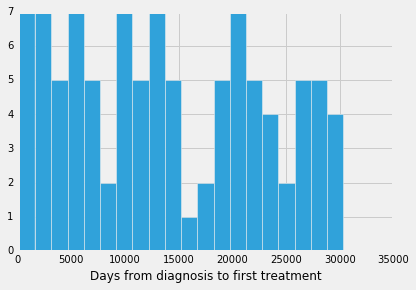

In [18]:
pt_grouped = patdemoadmin_df.groupby('patient_id')
with plt.style.context('fivethirtyeight'):
    plt.hist(pt_grouped['days_from_diag_to_admin'].min(),histtype="barstacked",
             label=pt_grouped['gender'].first().values,bins=20)
    plt.xlabel('Days from diagnosis to first treatment')

#print pt_grouped.groups
print 'Mean:', pt_grouped['days_from_diag_to_admin'].min().mean()
ptgenad_gp = pt_grouped[['gender','days_from_diag_to_admin']].min()
print 'Female mean:', ptgenad_gp[ptgenad_gp['gender']=='female']['days_from_diag_to_admin'].mean()
print 'Male mean:', ptgenad_gp[ptgenad_gp['gender']=='male']['days_from_diag_to_admin'].mean()
from scipy.stats import ttest_ind
ttest_ind(ptgenad_gp[ptgenad_gp['gender']=='female']['days_from_diag_to_admin'],
                             ptgenad_gp[ptgenad_gp['gender']=='male']['days_from_diag_to_admin'])

The average time between a patient's initial diagnosis date and a patient's first treatment is 14025 days. For femal patient's the mean was 15114 days and for male patient's it was 12694. These two means are not different in a statistically significant way (indepentdent t-test, alpha=.05, pvalue=.21). 

In [19]:
#patdemoadmin_df.to_csv('patdemoadmin.csv')